# Family cross-validation analysis

[description]

## Imports and configuration

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Import custom functions
from diabnet.ensemble import Ensemble
from diabnet.analysis.report import DiabNetReport
from diabnet.analysis.analysis import barplot

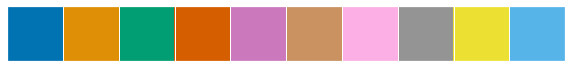

In [2]:
# Configuring IPython 
%load_ext autoreload
%autoreload 2

# Configuring matplotlib
%matplotlib inline

# Configuring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuring color palette
sns.set()
colors = sns.color_palette("colorblind")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-', 'grid.zorder': 0})

# Save plots to files
SAVE = True

# Verbosity
VERBOSE = False

## Loading family cross-validation results

In [3]:
# WARNINGS:
# - Make sure the families IDs are correct
# - Make sure the test data sufixes are correct

# Families IDs
family_ids = [0, 1, 3, 7, 10, 14, 30, 32, 33, 43]

# Prepare test data filepaths
tests = [
    f"famid_{famid}_positivo_1000_random_0.csv"
    for famid in family_ids
    
]

# Initiliaze data
data = {}

# Prepare data
for famid, test in zip(family_ids, tests):
    # Load ensemble
    ensemble = Ensemble(f"../results/models/families/famid{famid}/model-famid-{famid}-13-adamw-lc5-2021-05-25")
    
    # Create DiabNetReport
    tmp = DiabNetReport(ensemble, test, use_negatives=False)
    
    # Get number of positive and negative family members
    t = pd.read_csv(f"../data/visits_sp_unique_test_{test}").T2D.value_counts()
    
    # Calculate metrics
    data[f"famid{famid}"] = {
        "auc": tmp.auc(bootnum=1000, interval='HDI'),
        "f1": tmp.f1(bootnum=1000, interval='HDI'),
        "acc": tmp.acc(bootnum=1000, interval='HDI'),
        "bacc": tmp.bacc(bootnum=1000, interval='HDI'),
        "precision": tmp.precision(bootnum=1000, interval='HDI'),
        "sensitivity": tmp.sensitivity(bootnum=1000, interval='HDI'),
        "specificity": tmp.specificity(bootnum=1000, interval='HDI'),
        "avgprec": tmp.average_precision(bootnum=1000, interval='HDI'),
        "ece": tmp.ece(bootnum=10000, interval='HDI'),
        "mce": tmp.mce(bootnum=10000, interval='HDI'),
        "n": {'value': t[0] + t[1]},
        "pos%": {'value': t[1]/(t[0]+ t[1])},
    }

# Convert to pandas.DataFrame
tmp = data
raw_data = pd.DataFrame.from_dict(data, orient='index')
data = raw_data.applymap(lambda x: x['value'])
    
if VERBOSE:
    display(data)
    
if SAVE:
    if not os.path.exists("./results"):
        os.makedirs("./results")
    data.to_csv("./results/family_metrics.csv")

In [4]:
display(data)

,auc,f1,acc,bacc,precision,sensitivity,specificity,avgprec,ece,mce,n,pos%
famid0,0.967320,0.787879,0.901408,0.854575,0.812500,0.764706,0.944444,0.925306,0.123276,0.264960,71,0.239437
famid1,0.989130,0.919540,0.943548,0.928372,0.975610,0.869565,0.987179,0.983587,0.143924,0.347535,124,0.370968
famid3,0.950214,0.829268,0.967593,0.866975,0.944444,0.739130,0.994819,0.884712,0.089949,0.450116,216,0.106481
famid7,0.963710,0.861538,0.912621,0.909946,0.823529,0.903226,0.916667,0.946567,0.138976,0.341930,103,0.300971
famid10,0.932343,0.754717,0.896000,0.872112,0.689655,0.833333,0.910891,0.847324,0.127463,0.351542,125,0.192000
famid14,0.925000,0.744186,0.880435,0.851389,0.695652,0.800000,0.902778,0.851315,0.126069,0.354459,92,0.217391
famid30,0.973611,0.871795,0.945652,0.911111,0.894737,0.850000,0.972222,0.918395,0.147857,0.349837,92,0.217391
famid32,0.975694,0.848485,0.924242,0.878472,0.933333,0.777778,0.979167,0.943586,0.123783,0.434340,66,0.272727
famid33,0.989583,0.666667,0.887097,0.750000,1.000000,0.500000,1.000000,0.970606,0.141675,0.541449,62,0.225806
famid43,0.956667,0.880000,0.918919,0.918333,0.846154,0.916667,0.920000,0.924901,0.139873,0.453333,74,0.324324


## Plot 1: Barplot of family cross-validation metrics

[description]: What we find out with this plot?

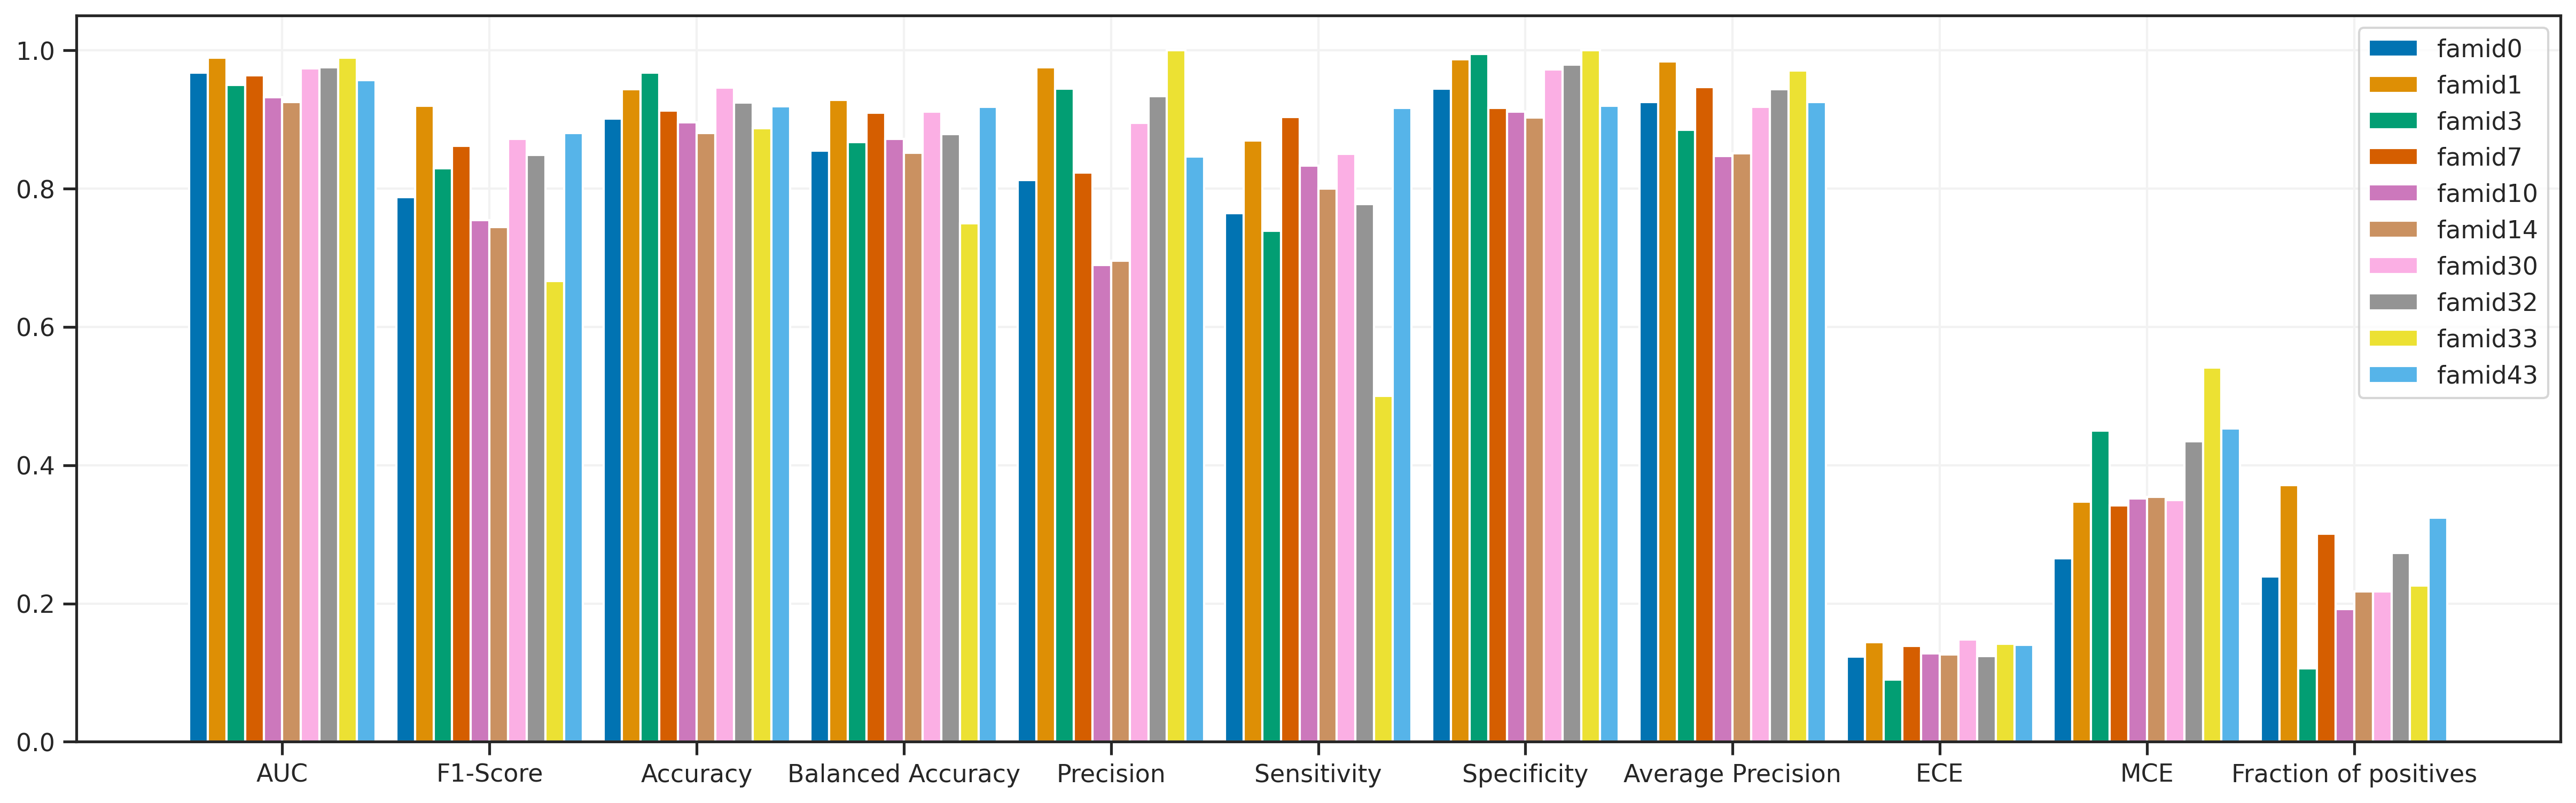

In [5]:
# Create figure
plt.figure(figsize=(20, 6), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Barplot metrics
barplot(
    ax,
    data,
    selection=[
        "auc",
        "f1",
        "acc",
        "bacc",
        "precision",
        "sensitivity",
        "specificity",
        "avgprec",
        "ece",
        "mce",
        "pos%",
    ],
    labels=[
        "AUC",
        "F1-Score",
        "Accuracy",
        "Balanced Accuracy",
        "Precision",
        "Sensitivity",
        "Specificity",
        "Average Precision",
        "ECE",
        "MCE",
        "Fraction of positives",
    ],
    rotation=0,
    ha="center",
    colors=colors,
    total_width=0.9,
    single_width=1,
)

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot1.svg")